<a href="https://colab.research.google.com/github/RenanNB360/Visao_Computacional_Colab/blob/main/Classificacao_de_Imagens/classificao_de_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import os
import shutil
import cv2
from sklearn.metrics import *
from google.colab.patches import cv2_imshow
from keras.models import save_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.__version__

'2.13.0'

# Carregamento das imagens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Projects Computing Vision/Classificação_imagens/arquivo/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file = path, mode= 'r')
zip_object.extractall('./')
zip_object.close()

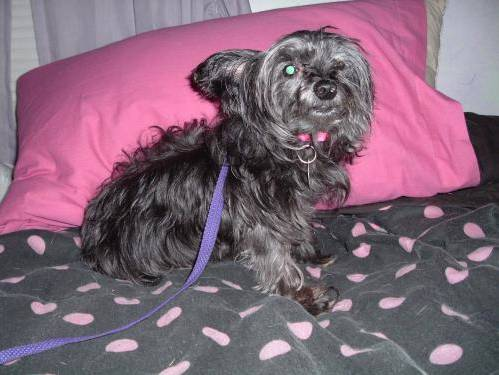

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/dog/dog.0.jpg')

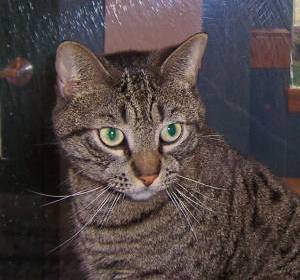

In [ ]:
tf.keras.preprocessing.image.load_img('/content/cat_dog_2/training_set/cat/cat.1.jpg')

In [ ]:
!mkdir /content/dataset/

In [ ]:
destino = '/content/dataset'

In [ ]:
def selecao_imagens(path, destino):

  max_size_train = 1000
  max_size_test = 250

  subdirs = [os.path.join(path, f) for f in os.listdir(path) if not os.path.basename(f).startswith(".")]

  for subdir in subdirs:
    name1 = subdir.split(os.path.sep)[-1]
    condicao = name1.split('_')[0]
    name1 = os.path.join(destino, name1)
    os.makedirs(name1, exist_ok=True)
    sub = [os.path.join(subdir, f) for f in os.listdir(subdir) if not os.path.basename(f).startswith(".")]

    for subsub in sub:
      name2 = subsub.split(os.path.sep)[-1]
      name2 = os.path.join(name1, name2)
      os.makedirs(name2, exist_ok=True)

      count = 0
      for nome_origem in os.listdir(subsub):

        if 'test' == condicao:
          if count < max_size_test:

            diretorio_origem = os.path.join(subsub, nome_origem)
            diretorio_destino = os.path.join(name2, nome_origem)

            shutil.copy(diretorio_origem, diretorio_destino)

            count += 1

        else:
          if count < max_size_train:

            diretorio_origem = os.path.join(subsub, nome_origem)
            diretorio_destino = os.path.join(name2, nome_origem)

            shutil.copy(diretorio_origem, diretorio_destino)

            count += 1

In [ ]:
path = '/content/cat_dog_2/'
selecao_imagens(path, destino)

In [ ]:
def mostra_quantidade(destino):
  subdirs = [os.path.join(destino, f) for f in os.listdir(destino)]
  for sub in subdirs:
    subsub = [os.path.join(sub, f) for f in os.listdir(sub)]
    for dir in subsub:
      print(f'Foram copiados {len(os.listdir(dir))} imagens para o diretorio: {dir}')

In [ ]:
mostra_quantidade(destino)

Foram copiados 1000 imagens para o diretorio: /content/dataset/training_set/cat
Foram copiados 1000 imagens para o diretorio: /content/dataset/training_set/dog
Foram copiados 250 imagens para o diretorio: /content/dataset/test_set/cat
Foram copiados 250 imagens para o diretorio: /content/dataset/test_set/dog


# Base de treinamento e teste

In [ ]:
gerador_treinamento = ImageDataGenerator(rescale=1./255,
                                         rotation_range=7,
                                         horizontal_flip=True,
                                         zoom_range=0.2)

In [ ]:
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/dataset/training_set',
                                                              target_size=(64,64),
                                                              batch_size = 32,
                                                              class_mode = 'categorical',
                                                              shuffle = True)

Found 2000 images belonging to 2 classes.


In [ ]:
dataset_treinamento.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1./255)

In [ ]:
dataset_teste = gerador_teste.flow_from_directory('/content/dataset/test_set',
                                                  target_size = (64, 64),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 500 images belonging to 2 classes.


# Construção e treinamento da rede neural

In [ ]:
network = Sequential()
network.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Flatten())

network.add(Dense(units = 577, activation = 'relu'))
network.add(Dense(units = 577, activation = 'relu'))
network.add(Dense(units = 2, activation = 'softmax'))

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

In [ ]:
network.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
historico = network.fit(dataset_treinamento, epochs = 500)

Epoch 1/500
63/63 [==============================] - 18s 98ms/step - loss: 0.6985 - accuracy: 0.5125
Epoch 2/500
63/63 [==============================] - 5s 84ms/step - loss: 0.6842 - accuracy: 0.5520
Epoch 3/500
63/63 [==============================] - 6s 93ms/step - loss: 0.6645 - accuracy: 0.5915
Epoch 4/500
63/63 [==============================] - 5s 87ms/step - loss: 0.6450 - accuracy: 0.6250
Epoch 5/500
63/63 [==============================] - 5s 75ms/step - loss: 0.6374 - accuracy: 0.6460
Epoch 6/500
63/63 [==============================] - 6s 99ms/step - loss: 0.6108 - accuracy: 0.6625
Epoch 7/500
63/63 [==============================] - 5s 75ms/step - loss: 0.5838 - accuracy: 0.6955
Epoch 8/500
63/63 [==============================] - 7s 107ms/step - loss: 0.5734 - accuracy: 0.7070
Epoch 9/500
63/63 [==============================] - 6s 90ms/step - loss: 0.5426 - accuracy: 0.7270
Epoch 10/500
63/63 [==============================] - 5s 76ms/step - loss: 0.5363 - accuracy: 0.72

# Avaliação da rede neural

In [ ]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
previsoes = network.predict(dataset_teste)
previsoes

500/500 [==============================] - 2s 3ms/step


array([[9.99558866e-01, 4.41081123e-04],
       [1.00000000e+00, 1.43232155e-08],
       [2.54223138e-01, 7.45776892e-01],
       [9.54794407e-01, 4.52055261e-02],
       [1.76844761e-01, 8.23155224e-01],
       [9.99974132e-01, 2.58336568e-05],
       [3.43981981e-01, 6.56018078e-01],
       [9.67440188e-01, 3.25597972e-02],
       [4.65851784e-01, 5.34148157e-01],
       [8.01462412e-01, 1.98537633e-01],
       [5.87224914e-03, 9.94127750e-01],
       [1.00000000e+00, 4.58420404e-24],
       [9.99488711e-01, 5.11275954e-04],
       [1.99550781e-02, 9.80044901e-01],
       [1.17583331e-02, 9.88241613e-01],
       [9.28119957e-01, 7.18800351e-02],
       [9.95535374e-01, 4.46466124e-03],
       [9.66400746e-03, 9.90335941e-01],
       [9.99994040e-01, 5.97501548e-06],
       [1.29304337e-03, 9.98706937e-01],
       [7.84193635e-01, 2.15806335e-01],
       [9.99998093e-01, 1.84952876e-06],
       [9.76237535e-01, 2.37624124e-02],
       [1.00000000e+00, 9.35884259e-09],
       [3.229289

In [ ]:
previsoes = np.argmax(previsoes, axis = 1)
previsoes

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
accuracy_score(dataset_teste.classes, previsoes)

0.722

In [ ]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

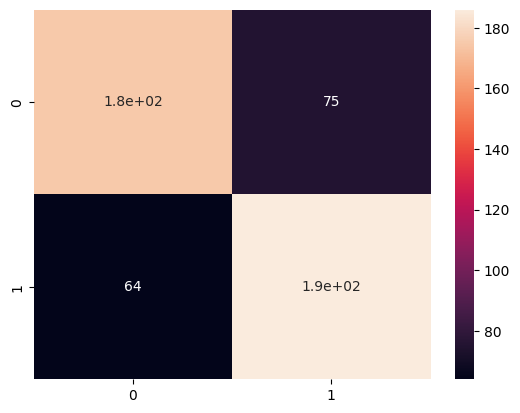

In [ ]:
cm = confusion_matrix(dataset_teste.classes, previsoes)
sns.heatmap(cm, annot = True);

In [ ]:
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       250
           1       0.71      0.74      0.73       250

    accuracy                           0.72       500
   macro avg       0.72      0.72      0.72       500
weighted avg       0.72      0.72      0.72       500



# Salvando e carregando a rede neural

In [ ]:
model_json = network.to_json()
with open('network.json', 'w') as json_file:
  json_file.write(model_json)

In [ ]:
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-30-551679fc671c>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')


In [ ]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 64, 64, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bia

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

# Classificação de uma única imagem

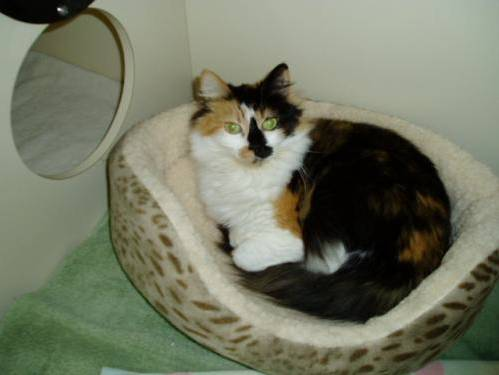

In [ ]:
imagem = cv2.imread('/content/cat_dog_2/test_set/cat/cat.3954.jpg')
cv2_imshow(imagem)

In [ ]:
imagem.shape

(375, 499, 3)

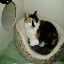

In [ ]:
imagem = cv2.resize(imagem, (64,64))
cv2_imshow(imagem)

In [ ]:
imagem

array([[[  4,   4,   4],
        [  3,   3,   3],
        [  4,   6,   6],
        ...,
        [163, 177, 165],
        [162, 172, 160],
        [159, 169, 157]],

       [[  2,   5,   4],
        [  0,   2,   1],
        [  0,   2,   2],
        ...,
        [163, 177, 165],
        [159, 173, 161],
        [157, 171, 159]],

       [[ 81,  88,  86],
        [  0,   2,   2],
        [  2,   4,   4],
        ...,
        [161, 178, 165],
        [156, 174, 161],
        [154, 172, 159]],

       ...,

       [[ 53,  85,  60],
        [ 57,  89,  64],
        [ 75, 108,  81],
        ...,
        [ 40,  58,  40],
        [ 25,  40,  23],
        [ 24,  39,  22]],

       [[ 55,  87,  62],
        [ 63,  95,  70],
        [ 66,  99,  72],
        ...,
        [ 74,  94,  76],
        [ 62,  91,  72],
        [ 52,  80,  63]],

       [[ 56,  86,  61],
        [ 63,  99,  74],
        [ 64, 100,  75],
        ...,
        [ 72,  99,  79],
        [ 62,  91,  76],
        [ 55,  82,  72]]

In [ ]:
imagem = imagem / 255
imagem

array([[[0.01568627, 0.01568627, 0.01568627],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01568627, 0.02352941, 0.02352941],
        ...,
        [0.63921569, 0.69411765, 0.64705882],
        [0.63529412, 0.6745098 , 0.62745098],
        [0.62352941, 0.6627451 , 0.61568627]],

       [[0.00784314, 0.01960784, 0.01568627],
        [0.        , 0.00784314, 0.00392157],
        [0.        , 0.00784314, 0.00784314],
        ...,
        [0.63921569, 0.69411765, 0.64705882],
        [0.62352941, 0.67843137, 0.63137255],
        [0.61568627, 0.67058824, 0.62352941]],

       [[0.31764706, 0.34509804, 0.3372549 ],
        [0.        , 0.00784314, 0.00784314],
        [0.00784314, 0.01568627, 0.01568627],
        ...,
        [0.63137255, 0.69803922, 0.64705882],
        [0.61176471, 0.68235294, 0.63137255],
        [0.60392157, 0.6745098 , 0.62352941]],

       ...,

       [[0.20784314, 0.33333333, 0.23529412],
        [0.22352941, 0.34901961, 0.25098039],
        [0.29411765, 0

In [ ]:
imagem.shape

(64, 64, 3)

In [ ]:
imagem = imagem.reshape(-1, 64, 64, 3)
imagem.shape

(1, 64, 64, 3)

In [ ]:
previsao = network_loaded.predict(imagem)
previsao

1/1 [==============================] - 0s 137ms/step


array([[0.99610716, 0.00389279]], dtype=float32)

In [ ]:
previsao = np.argmax(previsao)
previsao

0

In [ ]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
if previsao == 0:
  print('Cat')
else:
  print('Dog')

Cat
